In [2]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install matplotlib
!pip install pickle
!pip install os
!pip install time

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [4]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install coloredlogs

Defaulting to user installation because normal site-packages is not writeable


In [7]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install pytorch_lightning

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
print(os.getcwd())
import time

#import empirical cdf
import sys
sys.path.append(os.path.abspath('streamlined_mop/src'))

from check_ecdf import get_empirical_cdf
from core import Config

/home/sultand/mop_modifications


In [2]:
#experiment details
config = Config()
trainA = config.dataset_typ
valA = config.val_dataset_typ
num_val_systems = config.num_val_tasks
context_len = config.n_positions
print('context_len:', context_len)
print('trainA:', trainA)
print('valA:', valA)
print("num_val_systems:", num_val_systems)
C_dist = config.C_dist
ckpt_step = 192000
experiment = '240615_182401.2139c3_gaussA_gauss_C'


context_len: 250
trainA: gaussA
valA: gaussA
num_val_systems: 1000


In [3]:
#print the absolute path of the experiment
print(os.path.abspath(f"../mop_modifications/streamlined_mop/outputs/GPT2/{experiment}/prediction_errors{C_dist}_step={str(ckpt_step)}.ckpt/{valA}_err_lss.pkl"))

#load prediction errors

with open(f"../mop_modifications/streamlined_mop/outputs/GPT2/{experiment}/prediction_errors{C_dist}_step={str(ckpt_step)}.ckpt/{valA}_err_lss.pkl", 'rb') as f:
    err_lss = pickle.load(f)


/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/240615_182401.2139c3_gaussA_gauss_C/prediction_errors_gauss_C_step=192000.ckpt/gaussA_err_lss.pkl


In [20]:
for key in err_lss.keys():
    print(key, err_lss[key].shape)

Kalman (1000, 2000, 251)
MOP (1000, 2000, 251)
MOP_analytical (1000, 2000, 251)
Zero (1000, 2000, 251)
Analytical_Kalman (1000, 250)
OLS_ir_1 (1000, 2000, 251)
OLS_analytical_ir_1 (1000, 2000, 251)
OLS_ir_2_unreg (1000, 2000, 251)
OLS_analytical_ir_2_unreg (1000, 2000, 251)
OLS_ir_2 (1000, 2000, 251)
OLS_analytical_ir_2 (1000, 2000, 251)
OLS_ir_3 (1000, 2000, 251)
OLS_analytical_ir_3 (1000, 2000, 251)


[ 50 150 250]
MOP (1000, 2000, 251)
idx: 50
idx: 150
idx: 250
Analytical_Kalman (1000, 250)
(2000000, 251)
idx: 50
idx: 150
idx: 250
OLS_ir_1 (1000, 2000, 251)
idx: 50
idx: 150
idx: 250
OLS_ir_2 (1000, 2000, 251)
idx: 50
idx: 150
idx: 250
OLS_ir_3 (1000, 2000, 251)
idx: 50
idx: 150
idx: 250


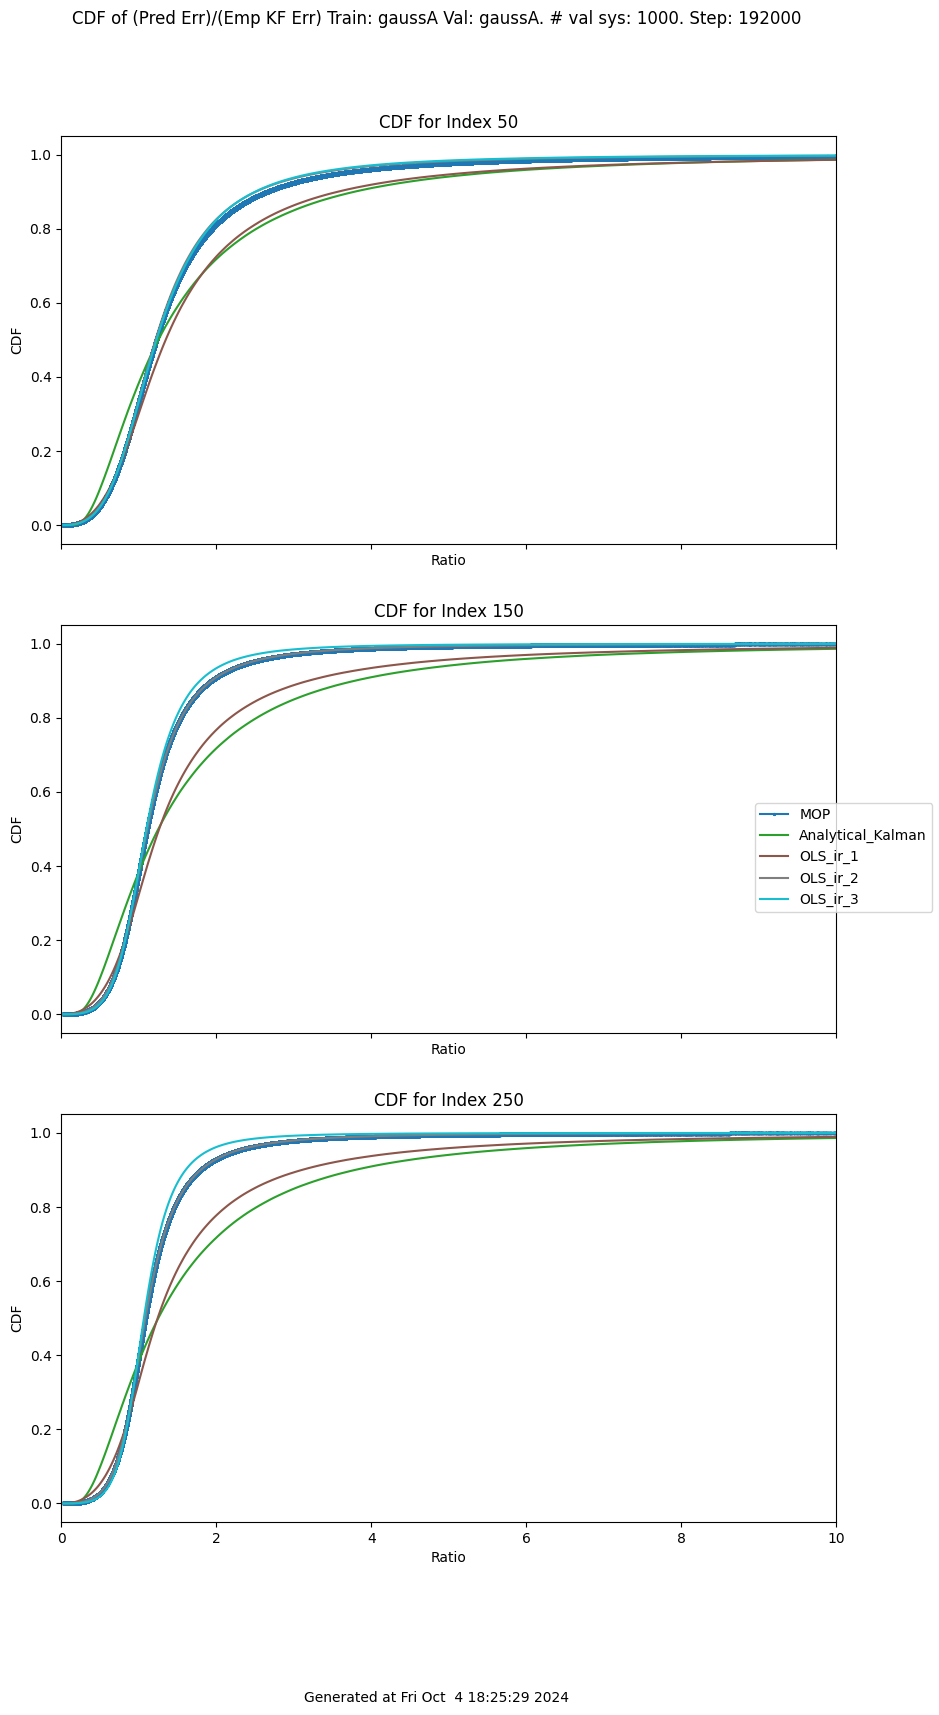

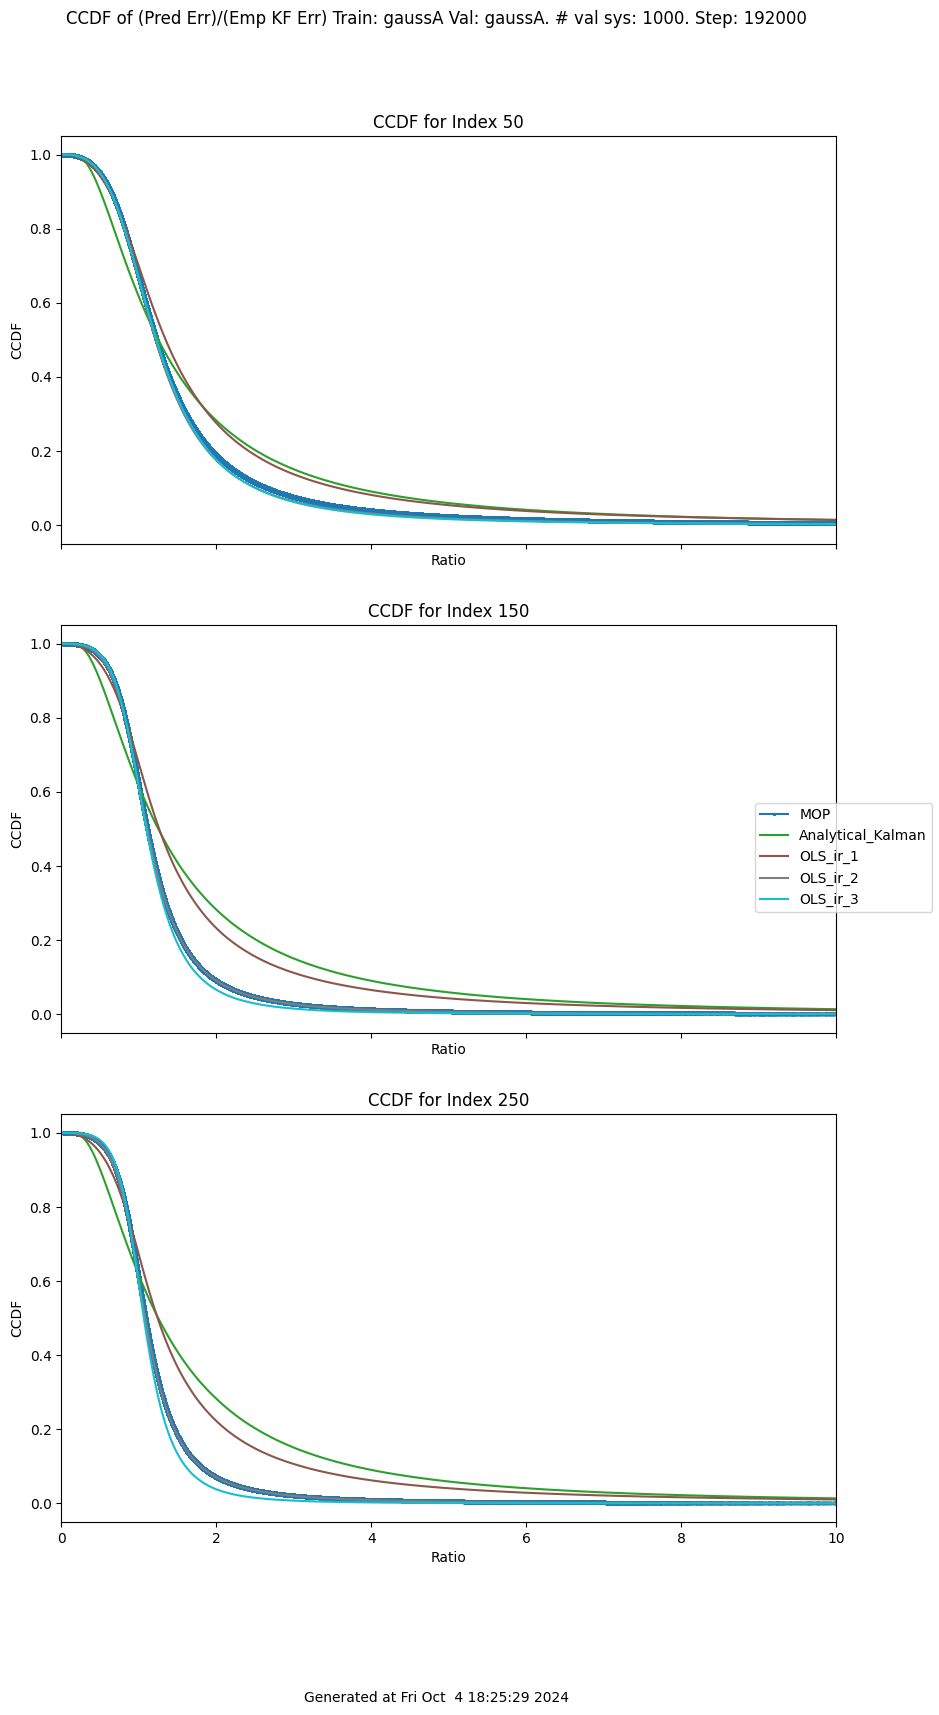

In [12]:
#give a list of colors that is as long as the len of err_lss.keys()
colors = plt.cm.tab10(np.linspace(0, 1, 5))

m = 3
xlim = 10
# choose m evenly spaced indexes between 50 and context_len
idxs = np.linspace(50, context_len, m).astype(int)
print(idxs)

#create a figure with subplots for each of the m indexes for the cdfs
fig_cdf, ax_cdf = plt.subplots(m, 1, figsize=(10, 18), sharex=True)

#create a figure with subplots for each of the m indexes for the ccdfs
fig_ccdf, ax_ccdf = plt.subplots(m, 1, figsize=(10, 18), sharex=True)

handles_cdf = []
handles_ccdf = []
labels = []

col = 0
for (name, errs) in err_lss.items():

    plot_flag = False
    if not (name == "Analytical_Kalman" or name == "Kalman" or name == "OLS_ir_2_unreg" or "analytical" in name or name == "Zero"):

        print(name, errs.shape)
        labels.append(name)
        ratios = errs/err_lss["Kalman"]

        #flatten the ratios along axis 0 but keep axis 2
        ratios = ratios.reshape(-1, ratios.shape[2])

        plot_flag = True
    
    elif name == "Analytical_Kalman": #plot the analytical kalman filter
        print(name, errs.shape)
        labels.append(name)
        t = np.arange(err_lss["Kalman"].shape[-1])
        #take the reciprocal of every element in err_lss["Kalman"]
        rec_kalman = 1/err_lss["Kalman"]
        #multiply rec_kalman by err_ls[:][0] elementwise
        irr_err = errs[:,0]
        ratios = rec_kalman * irr_err[:,np.newaxis, np.newaxis]
        #flatten the ratios along axis 0 but keep axis 2
        ratios = ratios.reshape(-1, ratios.shape[2])
        print(ratios.shape)

        plot_flag = True

    if plot_flag:
        i = 0
        for idx in idxs:
            print(f"idx: {idx}")
            #get the empirical cdf of the ratios
            ecdf = get_empirical_cdf(ratios[:, idx])

            #plot the cdf
            line_cdf, = ax_cdf[i].step(ecdf.x, ecdf.y, where='post', label=name, marker= "*" if name == "MOP" else None, color=colors[col], markersize=2)
            ax_cdf[i].set_title(f'CDF for Index {idx}')
            ax_cdf[i].set_ylabel('CDF')
            ax_cdf[i].set_xlabel('Ratio')
            ax_cdf[i].set_xlim([0, xlim])


            #plot the ccdf
            line_ccdf, = ax_ccdf[i].step(ecdf.x, 1-ecdf.y, where='post', label=name, marker= "*" if name == "MOP" else None, color=colors[col], markersize=2)
            ax_ccdf[i].set_title(f'CCDF for Index {idx}')
            ax_ccdf[i].set_ylabel('CCDF')
            ax_ccdf[i].set_xlabel('Ratio')
            ax_ccdf[i].set_xlim([0, xlim])

            i += 1

        handles_cdf.append(line_cdf)
        handles_ccdf.append(line_ccdf)
        col += 1

fig_cdf.legend(handles_cdf, labels, loc='center right')
fig_ccdf.legend(handles_ccdf, labels, loc='center right')

#set the title of the figures to include training and validation datasets, number of validation systems checkpoint step
fig_cdf.suptitle(f'CDF of (Pred Err)/(Emp KF Err) Train: {trainA} Val: {valA}. # val sys: {num_val_systems}. Step: {ckpt_step}',y=0.95)
fig_ccdf.suptitle(f'CCDF of (Pred Err)/(Emp KF Err) Train: {trainA} Val: {valA}. # val sys: {num_val_systems}. Step: {ckpt_step}',y=0.95)

#set a caption that has the timestep of the plot
fig_cdf.text(0.5, 0.01, f'Generated at {time.ctime()}', ha='center')
fig_ccdf.text(0.5, 0.01, f'Generated at {time.ctime()}', ha='center')

#save the figures
#set the filename to include the training and validation datasets, number of validation systems, the checkpoint step, and the timestamp
filename_cdf = f'cdf_train_{trainA}_val_{valA}_val_sys_{num_val_systems}_step_{ckpt_step}_{time.time()}.png'
filename_ccdf = f'ccdf_train_{trainA}_val_{valA}_val_sys_{num_val_systems}_step_{ckpt_step}_{time.time()}.png'

# set the filepath to the figures directory within the experiment directory
filepath_cdf = os.path.abspath(f"../mop_modifications/streamlined_mop/outputs/GPT2/{experiment}/figures/{filename_cdf}")
filepath_ccdf = os.path.abspath(f"../mop_modifications/streamlined_mop/outputs/GPT2/{experiment}/figures/{filename_ccdf}")

#save the figures
fig_cdf.savefig(filepath_cdf)
fig_ccdf.savefig(filepath_ccdf)

